In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

c:\anaconda3\envs\tensor_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from konlpy.tag import Okt
from tabulate import tabulate
from sentence_transformers import SentenceTransformer, util

In [3]:
print("슝=3")

슝=3


In [4]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super().get_config()
        config.update({
            "position": self.position,
            "d_model": self.d_model
        })
        return config

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            pos=tf.range(position, dtype=tf.float32)[:, tf.newaxis],  # ✅ 올바른 인자명
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / tf.pow(10000., (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return pos * angle_rates

In [5]:
print("슝=3")

슝=3


In [6]:
sample_pos_encoding = PositionalEncoding(50, 512)

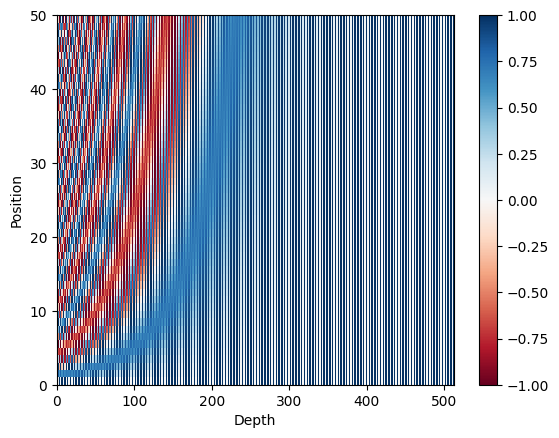

In [7]:
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
#plt.show()

In [8]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [9]:
print("슝=3")

슝=3


In [10]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0
        self.depth = d_model // num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads
        })
        return config

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # Scaled Dot-Product Attention 적용
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        # 다시 원래 차원으로 변환
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 Dense 적용
        outputs = self.dense(concat_attention)

        return outputs

In [11]:
print("슝=3")

슝=3


In [12]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [13]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [14]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [15]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [16]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [17]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [18]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [19]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [20]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [21]:
print("슝=3")

슝=3


In [22]:
# 파일 경로 설정
file_path = "ChatbotData_utf8sig.csv"

In [23]:
# CSV 파일 읽기 (UTF-8-SIG 인코딩)
df = pd.read_csv(file_path, encoding="utf-8-sig")

In [24]:
# Q, A 열이 존재하는지 확인
path_to_movie_lines = None
path_to_movie_conversations = None
if "Q" in df.columns and "A" in df.columns:
    # 질문과 답변 리스트로 변환
    path_to_movie_lines = df["Q"].tolist()
    path_to_movie_conversations = df["A"].tolist()

    print(f"총 {len(path_to_movie_lines)}개의 대화 데이터가 로드되었습니다.")
else:
    print("CSV 파일에 'Q', 'A' 컬럼이 없습니다. 파일을 확인하세요.")

총 11823개의 대화 데이터가 로드되었습니다.


In [25]:
print("슝=3")

슝=3


In [26]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [27]:
# 전처리 함수
# 🔧 데이터 전처리 함수 수정됨
def preprocess_sentence(sentence):
    """문장을 정제하고 전처리하는 함수"""
    sentence = sentence.lower().strip()  # 소문자 변환 및 앞뒤 공백 제거
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 구두점과 단어 사이 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)  # 연속된 공백 제거
    sentence = re.sub(r"[^a-zA-Z0-9가-힣?.!,]+", " ", sentence)  # 영문, 한글, 숫자, 구두점 제외 삭제
    sentence = sentence.strip()  # 최종 공백 정리
    return sentence  # 🔧 수정됨
print("슝=3")

슝=3


In [28]:
# 🔧 질문과 답변의 중복 제거 및 데이터 정리
def load_conversations():
    """파일이 아니라 리스트 데이터를 직접 사용하여 질문-답변 쌍을 생성"""
    id2line = {}
    for i in range(len(path_to_movie_lines)):
        id2line[i] = preprocess_sentence(path_to_movie_lines[i])  # 🔧 데이터 정제 추가됨

    inputs, outputs = [], []
    for i in range(len(path_to_movie_lines)):
        if i < len(path_to_movie_conversations):
            inputs.append(preprocess_sentence(path_to_movie_lines[i]))  # 🔧 데이터 정제 추가됨
            outputs.append(preprocess_sentence(path_to_movie_conversations[i]))  # 🔧 데이터 정제 추가됨

    # 🔧 중복 제거 및 정제
    unique_data = list(set(zip(inputs, outputs)))  # 중복된 질문-답변 제거
    inputs, outputs = zip(*unique_data)  # 리스트로 변환

    print(f"총 {len(inputs)}개의 정제된 질문-응답 쌍이 로드되었습니다.")  # 🔧 출력 메시지 수정됨
    return list(inputs), list(outputs)  # 🔧 반환 방식 수정됨

In [29]:
print("슝=3")

슝=3


In [30]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

총 11749개의 정제된 질문-응답 쌍이 로드되었습니다.
전체 샘플 수 : 11749
전체 샘플 수 : 11749


In [31]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 한 번 사는 인생인데
전처리 후의 22번째 답변 샘플: 멋진 말이에요 .


In [32]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐


In [33]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

슝=3 


In [34]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [35]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8123]
END_TOKEN의 번호 : [8124]


In [36]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8125


In [37]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [23, 411, 479, 2501, 1387]
정수 인코딩 후의 21번째 답변 샘플: [869, 1887, 1]


In [38]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [39]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [40]:
print("슝=3")

슝=3


In [41]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8125
필터링 후의 질문 샘플 개수: 11749
필터링 후의 답변 샘플 개수: 11749


In [42]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

In [43]:
# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

In [44]:
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


In [45]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


In [46]:
tf.keras.backend.clear_session()

In [47]:
# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

In [48]:
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [49]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3134208     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [50]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [51]:
print("슝=3")

슝=3


In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


In [53]:
sample_learning_rate = CustomSchedule(d_model=128)

Text(0.5, 0, 'Train Step')

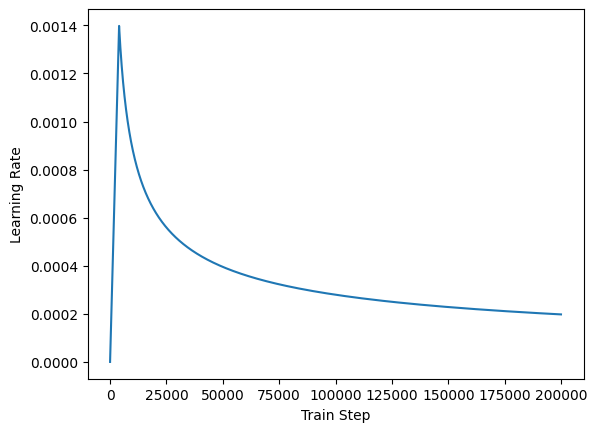

In [54]:
plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [55]:
learning_rate = CustomSchedule(D_MODEL)

In [56]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [57]:
def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [58]:
# 모델 저장 경로 설정
model_path = "kor_up_chatbot_transformer.h5"

In [59]:
# 모델이 존재하는지 확인
if os.path.exists(model_path):
    print(f"저장된 모델을 불러옵니다: {model_path}")
    # 1. 모델을 먼저 정의
    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT
    )

    # 2. 가중치 로드
    model.load_weights(model_path)
else:
    print("모델이 존재하지 않습니다. 새로 훈련을 시작합니다.")

    # 모델 컴파일
    model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
    print("슝=3")

    # 훈련 진행
    EPOCHS = 30
    model.fit(dataset, epochs=EPOCHS, verbose=1)

    # 모델 저장
    model.save_weights(model_path)
    print(f"모델이 {model_path}로 저장되었습니다.")

저장된 모델을 불러옵니다: kor_up_chatbot_transformer.h5


In [60]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [61]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [62]:
import heapq

In [63]:
def decoder_inference_beam_search(sentence, beam_width=5):
    """Beam Search를 사용한 문장 생성"""
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 및 종료 토큰 추가
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # Beam Search 진행을 위한 우선순위 큐
    sequences = [(0.0, tf.expand_dims(START_TOKEN, axis=0))]  # (확률값, 출력 시퀀스)

    for _ in range(MAX_LENGTH):
        all_candidates = []

        for score, seq in sequences:
            predictions = model(inputs=[sentence, seq], training=False)
            predictions = predictions[:, -1, :]  # 마지막 단어 예측
            top_k_probs, top_k_ids = tf.nn.top_k(predictions, k=beam_width)  # 상위 k개 선택

            # 후보들 확장
            for i in range(beam_width):
                new_token = tf.expand_dims(top_k_ids[0, i], axis=0)  # 🔧 차원 확장 (1D -> [1])
                new_seq = tf.concat([seq, tf.expand_dims(new_token, axis=0)], axis=-1)  # 🔧 차원 수정
                new_score = score + tf.math.log(top_k_probs[0, i])  # 로그 확률 합산
                all_candidates.append((new_score, new_seq))

        # 상위 beam_width개의 후보만 유지
        sequences = heapq.nlargest(beam_width, all_candidates, key=lambda x: x[0])

        # 종료 토큰이 포함된 최상의 문장을 찾으면 조기 종료
        if any(tf.reduce_any(seq == END_TOKEN[0]) for _, seq in sequences):
            break

    # 가장 높은 확률을 가진 문장 선택
    best_sequence = sequences[0][1]
    best_sequence = tf.squeeze(best_sequence, axis=0)  # 차원 축소

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
    predicted_sentence = tokenizer.decode(
        [i for i in best_sequence.numpy() if i < tokenizer.vocab_size])

    return predicted_sentence

In [64]:
def sentence_generation_beam_search(sentence, beam_width=5):
    """Beam Search 기반 문장 생성 및 출력"""
    predicted_sentence = decoder_inference_beam_search(sentence, beam_width)

    print('입력 : {}'.format(sentence))
    print('출력 (Beam Search) : {}'.format(predicted_sentence))

    return predicted_sentence

In [65]:
# 평가용 모델 로드 (BERT 임베딩 사용)
embedding_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
okt = Okt()

In [66]:
# 평가 데이터셋 (입력 문장, 예상 출력)
input_sentences = [
    "오늘 점심 때 짜장면 어때?",
    "너는 에버랜드 가 보았니?",
    "오늘 저녁에 동네 한 바퀴 돌자?",
    "내일 우리 영화 보러 가자!"
]

In [67]:
expected_responses = [
    "짜장면 맛있죠!",
    "에버랜드 재밌어요!",
    "좋아요! 운동도 되고.",
    "영화 좋아요! 무슨 영화 볼까요?"
]

In [68]:
# 챗봇 응답 생성 (Beam Search 적용)
generated_responses = [sentence_generation_beam_search(sentence) for sentence in input_sentences]

입력 : 오늘 점심 때 짜장면 어때?
출력 (Beam Search) : 짜장면은 혼자 
입력 : 너는 에버랜드 가 보았니?
출력 (Beam Search) : 슬픈 이야기네요 .
입력 : 오늘 저녁에 동네 한 바퀴 돌자?
출력 (Beam Search) : 그 속에서 나오세요 .
입력 : 내일 우리 영화 보러 가자!
출력 (Beam Search) : 좋은 생각이에요 .


In [69]:
# 평가 지표 저장 리스트
results = []
smoothie = SmoothingFunction().method1  # BLEU 스무딩 적용

In [70]:
# 평가 실행
for idx, (input_sentence, expected_response, generated_response) in enumerate(zip(input_sentences, expected_responses, generated_responses), start=1):
    # 1. 코사인 유사도
    expected_embedding = embedding_model.encode(expected_response, convert_to_tensor=True)
    generated_embedding = embedding_model.encode(generated_response, convert_to_tensor=True)
    cosine_similarity = util.pytorch_cos_sim(expected_embedding, generated_embedding).item()

    # 2. BLEU 점수 (스무딩 + 형태소 분석 적용)
    reference = [okt.morphs(expected_response)]  # 형태소 분석 적용
    candidate = okt.morphs(generated_response)
    bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothie)

    # 3. 유창성 (Fluency) - 문장 길이 기반
    fluency_score = min(len(generated_response) / len(expected_response), 1.0)

    # 4. 관련성 (Relevance) - 입력 문장과의 의미 유사도
    input_embedding = embedding_model.encode(input_sentence, convert_to_tensor=True)
    relevance_score = util.pytorch_cos_sim(input_embedding, generated_embedding).item()

    # 5. 다양성 (Diversity) - 중복 단어 비율 분석
    unique_words = set(generated_response.split())
    diversity_score = len(unique_words) / max(len(generated_response.split()), 1)

    # 결과 저장 (번호 추가)
    results.append([idx, input_sentence, expected_response, generated_response,
                    round(cosine_similarity, 2), round(bleu_score, 2),
                    round(fluency_score, 2), round(relevance_score, 2),
                    round(diversity_score, 2)])

In [71]:
# 데이터프레임 생성
df = pd.DataFrame(results, columns=["번호", "입력 문장", "예상 출력", "AI 응답",
                                    "코사인 유사도", "BLEU 점수", "유창성", "관련성", "다양성"])

In [72]:
# 평균 점수 계산하여 추가 (번호 열 제외)
avg_scores = df.iloc[:, 4:].mean().round(2)
total_score = avg_scores.sum().round(2) * 25  # 100점 만점 변환

In [73]:
# 📌 평균 행 추가 (번호 열을 빈 값으로 설정)
df.loc[len(df)] = ["", "📌 평균", "-", "-"] + avg_scores.tolist()
# 📌 총점 (100점 기준) 행 추가 (번호 열을 빈 값으로 설정)
df.loc[len(df)] = ["", "📌 총점 (100점 기준)", "-", "-", "-", "-", "-", "-", total_score]

In [74]:
# 🔹 CSV 저장
csv_filename = "ai_chatbot_evaluation.csv"
df.to_csv(csv_filename, index=False, encoding="utf-8-sig")
print(f"\n✅ 평가 결과가 CSV 파일로 저장되었습니다: {csv_filename}")


✅ 평가 결과가 CSV 파일로 저장되었습니다: ai_chatbot_evaluation.csv


In [75]:
# 🔹 표 형태로 출력 (자동 인덱스 제거)
print("\n📌 AI 응답 평가 결과")
print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))  # 🔹 자동 인덱스 제거


📌 AI 응답 평가 결과
+--------+--------------------------------+--------------------------------+----------------------+-----------------+-------------+----------+----------+----------+
| 번호   | 입력 문장                      | 예상 출력                      | AI 응답              | 코사인 유사도   | BLEU 점수   | 유창성   | 관련성   |   다양성 |
+========+================================+================================+======================+=================+=============+==========+==========+==========+
| 1      | 오늘 점심 때 짜장면 어때?      | 짜장면 맛있죠!                 | 짜장면은 혼자        | 0.56            | 0.11        | 1.0      | 0.88     |     1    |
+--------+--------------------------------+--------------------------------+----------------------+-----------------+-------------+----------+----------+----------+
| 2      | 너는 에버랜드 가 보았니?       | 에버랜드 재밌어요!             | 슬픈 이야기네요 .    | 0.92            | 0.0         | 1.0      | 0.86     |     1    |
+--------+--------------------------------+----------------------------